Charu Aggarwal in his book Outlier Analysis classifies Outlier detection models in following groups:

1. Extreme Value Analysis: This is the most basic form of outlier detection and only good for 1-dimension data. In these types of analysis, it is assumed that values which are too large or too small are outliers. Z-test and Student’s t-test are examples of these statistical methods. These are good heuristics for initial analysis of data but they don’t have much value in multivariate settings. They can be used as final steps for interpreting outputs of other outlier detection methods.
2. Probabilistic and Statistical Models: These models assume specific distributions for data. Then using the expectation-maximization(EM) methods they estimate the parameters of the model. Finally, they calculate probability of membership of each data point to calculated distribution. The points with low probability of membership are marked as outliers.
3. Linear Models: These methods model the data into a lower dimensional sub-spaces with the use of linear correlations. Then the distance of each data point to plane that fits the sub-space is being calculated. This distance is used to find outliers. PCA(Principal Component Analysis) is an example of linear models for anomaly detection.
4. Proximity-based Models: The idea with these methods is to model outliers as points which are isolated from rest of observations. Cluster analysis, density based analysis and nearest neighborhood are main approaches of this kind.
5. Information Theoretic Models: The idea of these methods is the fact that outliers increase the minimum code length to describe a data set.
6. High-Dimensional Outlier Detection: Specifc methods to handle high dimensional sparse data

In [57]:
# Import Libraries

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer

from scipy.stats import skew

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [20]:
#Import Data
df_train = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\House_Prices\train.csv")
df_test = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\House_Prices\test.csv")


### Define Median Absolute Deviation Function

In [21]:
def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

### Remove Skew from SalesPrice data

** Select the last column as target**

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


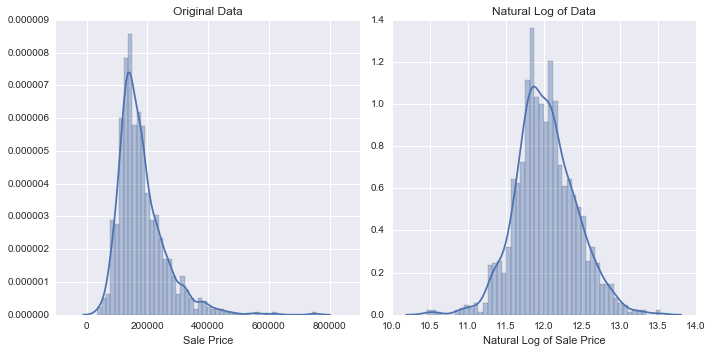

In [22]:
target = df_train[df_train.columns.values[-1]]
target_log = np.log(target)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(target, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(target_log, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

### Merge Train and Test to evaluate ranges and missing values
This was done primarily to ensure that Categorical data in the training and testing data sets were consistent.

In [23]:
df_train = df_train[df_train.columns.values[:-1]]
df = df_train.append(df_test, ignore_index = True)

### Find all categorical data

In [24]:
cats = []
for col in df.columns.values:
    if df[col].dtype == 'object':
        cats.append(col)

### Create separte datasets for Continuous vs Categorical
Creating two data sets allowed me to handle the data in more appropriate ways.

In [25]:
df_cont = df.drop(cats, axis=1)
df_cat = df[cats]

### Handle Missing Data for continuous data
1. If any column contains more than 50 entries of missing data, drop the column
2. If any column contains fewer that 50 entries of missing data, replace those missing values with the median for that column
(the median imputation used on missing values is very crude.
For example, Area features with missing values may be this way because the
property does not have that feature (e.g. a pool) so it would make more sense 
to set this to zero. )
3. Remove outliers using Median Absolute Deviation
4. Calculate skewness for each variable and if greater than 0.75 transform it
5. Apply the sklearn.Normalizer to each column

In [60]:
for col in df_cont.columns.values:
    if np.sum(df_cont[col].isnull()) > 50:
        #print("Removing Column: {}".format(col))
        df_cont = df_cont.drop(col, axis = 1)
    elif np.sum(df_cont[col].isnull()) > 0:
        #print("Replacing with Median: {}".format(col))
        median = df_cont[col].median()
        idx = np.where(df_cont[col].isnull())[0]
        #df_cont[col].iloc[idx] = median
        
        ##Feature creation is done by taking the square root of
           ##all numerical area features rather than the median give Random Regressor .011 rather than .14
        df_cont[col].iloc[idx] = np.sqrt

        outliers = np.where(is_outlier(df_cont[col]))
        df_cont[col].iloc[outliers] = median
        
        if skew(df_cont[col]) > 0.75:
            #print("Skewness Detected: {}".format(col))
            df_cont[col] = np.log(df_cont[col])
            df_cont[col] = df_cont[col].apply(lambda x: 0 if x == -np.inf else x)
        
        # df_cont[col] = Normalizer().fit_transform(df_cont[col].reshape(1,-1))[0]
        #Min-MaxScalar returns the RMSE = 0.01176 rather than 0.0118 using normalizer
        
        df_cont[col] = MinMaxScaler().fit_transform(df_cont[col].reshape(1,-1))[0]

### Handle Missing Data for Categorical Data
1. If any column contains more than 50 entries of missing data, drop the column
2. If any column contains fewer that 50 entries of missing data, replace those values with the 'MIA'
3. Apply the sklearn.LabelEncoder
4. For each categorical variable determine the number of unique values and for each, create a new column that is binary

In [61]:
for col in df_cat.columns.values:
    if np.sum(df_cat[col].isnull()) > 50:
        df_cat = df_cat.drop(col, axis = 1)
        continue
    elif np.sum(df_cat[col].isnull()) > 0:
        df_cat[col] = df_cat[col].fillna('MIA')
        
    df_cat[col] = LabelEncoder().fit_transform(df_cat[col])
    
    num_cols = df_cat[col].max()
    for i in range(num_cols):
        col_name = col + '_' + str(i)
        df_cat[col_name] = df_cat[col].apply(lambda x: 1 if x == i else 0)
        
    df_cat = df_cat.drop(col, axis = 1)

### Merge Numeric and Categorical Datasets and Create Training and Testing Data

In [62]:
df_new = df_cont.join(df_cat)

df_train = df_new.iloc[:len(df_train) - 1]
df_train = df_train.join(target_log)

df_test = df_new.iloc[len(df_train) + 1:]

X_train = df_train[df_train.columns.values[1:-1]]
y_train = df_train[df_train.columns.values[-1]]

X_test = df_test[df_test.columns.values[1:]]

In [104]:
df_test.shape

(1461, 206)

### Create Feature and Target Data Sets

In [94]:

labels_train = df_train[df_train.columns[1:-1]]
target_train = df_train[df_train.columns[-1]]

labels_test = df_test[df_test.columns[1:]]

In [ ]:
target = train["SalePrice"] # Note that we will take the Log of this when fitting - check the histogram of this feature
train = train.drop("SalePrice",axis=1)

dd = clean(pd.concat([train,test]))

train = dd[:len(train)]
test = dd[len(train):]


### Create Estimator and Apply Cross Validation using Random Forest Regressor

We can gauge the accuracy of our model by implementing an multi-fold cross validation and outputting the score. In this case I chose to run 15 iterations and output the score as Root Mean Squared Error.
The results range from ~0.11-0.17 with a mean of ~0.14.

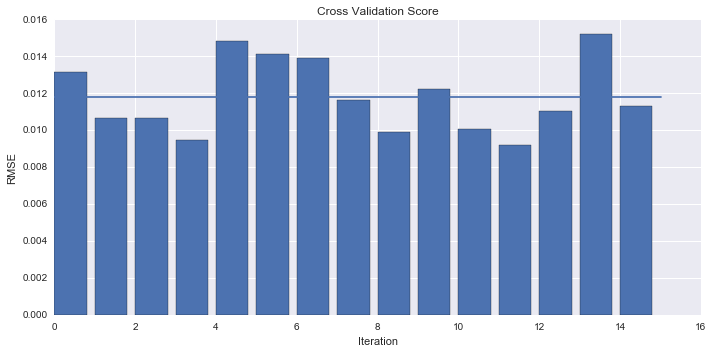

In [64]:
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(mean_squared_error, False)

clf_random = RandomForestRegressor(n_estimators=500, n_jobs=-1)
cv_score = np.sqrt(-cross_val_score(estimator=clf_random, X=X_train, y=y_train, cv=15, scoring = scorer))

plt.figure(figsize=(10,5))
plt.bar(range(len(cv_score)), cv_score)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')

plt.plot(range(len(cv_score) + 1), [cv_score.mean()] * (len(cv_score) + 1))
plt.tight_layout()

### Evaluate Model Parameter using Cross Validation for ridge regression
The main parameters that we can tweak to improve our model accuracy are alpha and solver. We can evaluate the RMSE for each set of solvers and alpha combinations.

In [43]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Ridge
scorer = make_scorer(mean_squared_error, False)

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
solvers = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']

cv_score = []
for i in solvers:
    for ii in alphas:
        clf_ridge = Ridge(alpha = ii, solver = i)
        cv_score.append(np.sqrt(-cross_val_score(estimator=clf_ridge, 
                                            X=labels_train, 
                                            y=target_train, 
                                            cv=15, 
                                            scoring = "neg_mean_squared_error")).mean())

### Visualize Validation Results

,svd,cholesky,lsqr,sparse_cg,sag,alpha
0,0.142497,0.142497,0.199157,0.195205,0.264384,0.05
1,0.143275,0.143275,0.199157,0.195205,0.264379,0.10
2,0.143678,0.143678,0.199157,0.195205,0.264391,0.30
3,0.143119,0.143119,0.199157,0.195205,0.264379,1.00
4,0.142298,0.142298,0.199157,0.195205,0.264384,3.00
5,0.142020,0.142020,0.199157,0.195205,0.264388,5.00
6,0.142010,0.142010,0.199157,0.195205,0.264388,10.00
7,0.142295,0.142295,0.199157,0.195205,0.264388,15.00
8,0.143426,0.143426,0.199157,0.195205,0.264391,30.00
9,0.144844,0.144844,0.199157,0.195205,0.264384,50.00


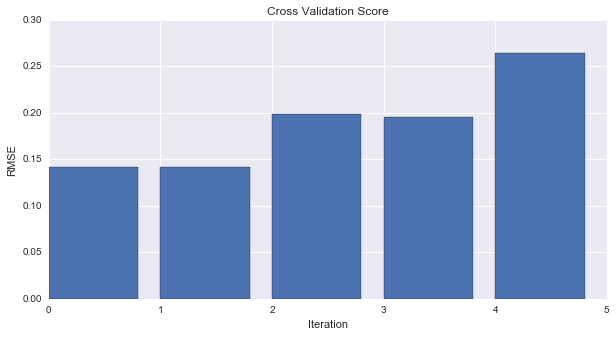

In [44]:
cv_score = np.reshape(cv_score, (5,11))
score = pd.DataFrame(cv_score).T
score.columns = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
score['alpha'] = alphas
score.set_index(['alpha'])

plt.figure(figsize=(10,5))
plt.bar(range(len(score[score.columns[:-1]].min().values)), score[score.columns[:-1]].min().values)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')


score

### Evaluate Feature Significance using Ridge Regression
Investigating feature importance is a relatively straight forward process:
1. Output feature importance coefficients
2. Map coefficients to their feature name
3. Sort features in descending order

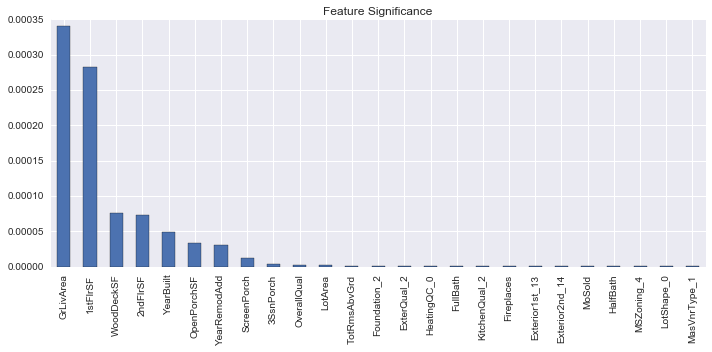

In [45]:
# Fit model with training data
clf_ridge.fit(labels_train, target_train)

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(clf.coef_ , index = labels_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

### Evaluate Feature Significance using Random Forest
Investigating feature importance is a relatively straight forward process:
1. Out feature importance coefficients
2. Map coefficients to their feature name
3. Sort features in descending order

Given our choice of model and methods for preprocessing data the most significant features are:
1. OverallQual
2. GrLivArea
3. TotalBsmtSF
4. GarageArea

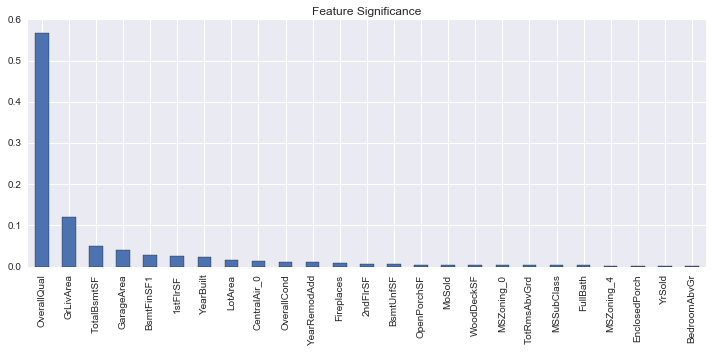

In [46]:
# Fit model with training data
clf_random.fit(X_train, y_train)

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(clf_random.feature_importances_, index = X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()


### Visualize Predicted vs. Actual Sales Price using Random Forest Regressor
In order to visualize our predicted values vs our actual values we need to split our data into training and testing data sets. This can easily be accomplished using sklearn's train_test_split module.
We will train the model using a random sampling of our data set and then compare visually against the actual values.

RMSE Score: 0.011768032723282255


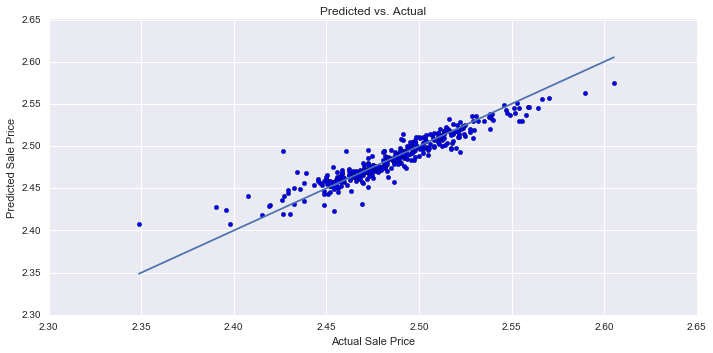

In [65]:
from sklearn.cross_validation import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)
clf_random = RandomForestRegressor(n_estimators=500, n_jobs=-1)

clf_random.fit(X_train1, y_train1)
y_pred = clf_random.predict(X_test1)

plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

cv_score = np.sqrt(-cross_val_score(clf_random, 
                                    labels_train, 
                                    target_train, 
                                    cv=15, 
                                    scoring = "neg_mean_squared_error"))

print("RMSE Score: {}".format(cv_score.mean()))

### Visualize Predicted vs. Actual Sales Price using Ridge Regression

RMSE Score: 0.011958878147891403


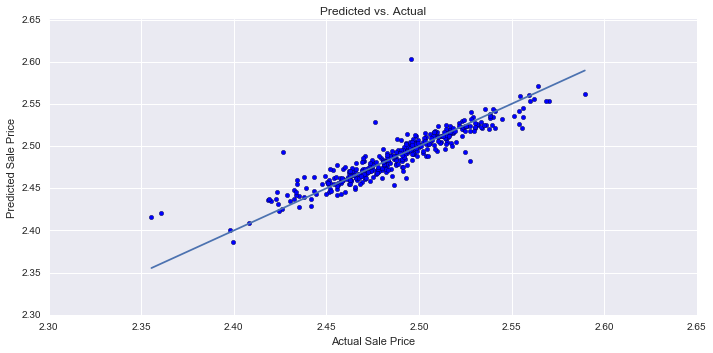

In [102]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(labels_train, target_train)

clf_ridge = Ridge(alpha = 15)
clf_ridge.fit(X_train, y_train)
y_pred = clf_ridge.predict(X_test)

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.tight_layout()


cv_score = np.sqrt(-cross_val_score(clf_ridge, 
                                    labels_train, 
                                    target_train, 
                                    cv=15, 
                                    scoring = "neg_mean_squared_error"))

print("RMSE Score: {}".format(cv_score.mean()))

### Assess Skew of SalesPrice data and Identify Outliers

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


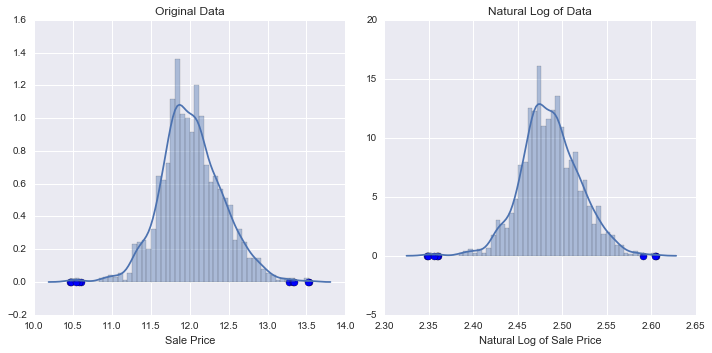

In [32]:
# Define Target Data
target = df_train[df_train.columns.values[-1]]
target_log = np.log(target)

# Identify indexes of outliers
outliers = np.where(is_outlier(target))
outliers_log = np.where(is_outlier(target_log))

# Create arrays for plotting purposes
x = target.iloc[outliers].astype(float).values
y = np.zeros(len(outliers[0]))

x_log = target_log.iloc[outliers_log].astype(float).values
y_log = np.zeros(len(outliers_log[0]))

# Plot Original Data
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(target, bins=50)
plt.scatter(x, y, c='b', s=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

# Plot Log Data
plt.subplot(1,2,2)
sns.distplot(target_log, bins=50)
plt.scatter(x_log, y_log, c='b', s=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

In [77]:
def rmse_cv(model): # Cross val using the competition scoring metric
    return(np.sqrt(-cross_val_score(model, X_train, np.log(target_train), scoring="neg_mean_squared_error", cv = 5)))

In [78]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
print("=====Lasso Regression RMSE=====")
for a in [1.0e-4,3.0e-4,1.0e-3,3.0e-3]:
    print(a, rmse_cv(Lasso(alpha = a)).mean())
    

=====Lasso Regression RMSE=====
0.0001 0.00525572577968
0.0003 0.0054882635285
0.001 0.0057346372173
0.003 0.00664579890741


In [79]:
print("=====Ridge Regression RMSE w/ alphas =====")
for a in np.arange(1,10,1):
    print(a, rmse_cv(Ridge(alpha = a)).mean())

=====Ridge Regression RMSE w/ alphas =====
1 0.00503115813219
2 0.00499099835106
3 0.00496790815969
4 0.00495369311695
5 0.00494457753172
6 0.00493864063856
7 0.00493481020521
8 0.00493244262034
9 0.00493112873691


In [80]:
print("=====ElasticNet RMSE w/ alphas =====")
#for a in [3.0e-4,1.0e-3,3.0e-3,1.0e-4]:
for a in np.arange(3.0e-4,3.0e-3,3.0e-4):
    print(a, rmse_cv(ElasticNet(alpha = a,max_iter=10000)).mean())

=====ElasticNet RMSE w/ alphas =====
0.0003 0.00537041293827
0.0006 0.0054883810618
0.0009 0.00553674684258
0.0012 0.00559821953712
0.0015 0.00564340675883
0.0018 0.00569575247539
0.0021 0.00575470541792
0.0024 0.00582268058474
0.0027 0.00589845766885
0.003 0.00598212857713


In [93]:
best_model

Ridge(alpha=6, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [85]:
# Best RMSE is Ridge with alpha = 6
best_model = Ridge(alpha= 6).fit(labels_train,np.log(target_train))

In [ ]:
# Output to CSV
test["SalePrice"] = np.exp(best_model.predict(X_test))
test[["SalePrice"]].to_csv("submit.txt")

In [ ]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import cross_validation
from sklearn import preprocessing

train_df = pd.read_csv('../input/train.csv', header=0)
test_df = pd.read_csv('../input/test.csv', header=0)
train_y = train_df['SalePrice']
test_id = test_df['Id']

train_df.drop('Id',axis=1,inplace=True)
train_df.drop('SalePrice',axis=1,inplace=True)
test_df.drop('Id',axis=1,inplace=True)

features = train_df.columns.values
consider = []
numerics = ['LotArea','LotFrontage','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath',
                'BsmtHalfBath','FullBath','HalfBath','Bedroom','Kitchen','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',
                'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YrSold']
i=1
for col in features:
        print("Including "+str(i)+": "+str(col))
        i+=1
        consider.append(col)
        if col not in numerics:
                le = preprocessing.LabelEncoder()
                train_df[col] = train_df[col].fillna("Missing")
                train_df[col] = le.fit_transform(train_df[col])
        else:
                train_df[col] = train_df[col].fillna(0)

        train = train_df[consider]
        X = train.as_matrix()
        Y = train_y.as_matrix()

        log_regressor = linear_model.LinearRegression()
        score2 = cross_validation.cross_val_score(log_regressor,X,Y,cv=5)
        print ("lin_reg: mean="+str(np.mean(score2))+" std="+str(np.std(score2)))